# Conflict Prediction

##### This notebook develops models to predict conflict outbreak in the Central African Republic using a dataset I constructed in ArcGIS

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN_class
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor as KNN_reg
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
import time
from sklearn.metrics import roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE
%matplotlib inline

## Importing and cleaning data

In [3]:
#Reading in dataset
df=pd.read_csv('car_data.csv')
df.head()

,gid,country,admin1,admin2,admin3,VACtest_co,VtestFat,elev_avg,elev_max,elev_min,...,high_edu_women,women_employed,men_employed,improved_water,no_toilet,house_electricity,gcppc05,ppp05,migration,births
0,141523,Central African Republic,Bamingui-Bangoran,Nd̩l̩,,0,0,695,819,494,...,8.6,82.500000,81.300003,46.700001,34.200001,1.0,565.894439,0.006708,85.461197,77.361198
1,136483,Central African Republic,Basse-Kotto,Alindao,,0,0,478,646,384,...,5.0,91.900002,87.099998,51.299999,34.400002,0.6,403.347188,0.061512,178.472000,2143.320068
2,139372,Central African Republic,Haut-Mbomou,Djemah,,0,0,707,803,621,...,5.0,91.900002,87.099998,51.299999,34.400002,0.6,546.174429,0.000679,0.000000,6.392040
3,139367,Central African Republic,Haute-Kotto,Yalinga,,0,0,692,787,589,...,8.6,82.500000,81.300003,46.700001,34.200001,1.0,608.517944,0.002891,40.948399,15.291800
4,137918,Central African Republic,Kemo,Sibut,,0,0,548,657,428,...,11.2,84.300003,82.400002,53.500000,19.200001,0.8,464.793097,0.023521,213.604004,423.678986


In [4]:
#Recoding into a binary classification problem (i.e. all observations with at least one conflict event = having conflict)
df.loc[df['VACtest_co']>0, 'VACtest_co']=1
df['VACtest_co'].value_counts()

0    119
1     86
Name: VACtest_co, dtype: int64

In [1]:
def getPctMissing(series):
    num = series.isnull().sum()
    den=series.shape[0]
    #den = series.count()
    return 100*(num/den)


In [7]:
# List of columns to be converted to floating point
to_float = ['elev_avg', 'elev_max', 'elev_min', 'bdist3', 'capdist','ttime','light_max','light_min','ethgrp_num','infant_mortality','under5_mortality','NbrConflic','NbrFat']

# Converted columns to floating point
for feature_name in to_float:
    df[feature_name] = df[feature_name].astype(float)
    
    
df.head()

,VACtest_co,elev_avg,elev_max,elev_min,wri_cenafr,temp,prec,bdist3,capdist,ttime,...,high_edu_women,women_employed,men_employed,improved_water,no_toilet,house_electricity,gcppc05,ppp05,migration,births
0,0,695.0,819.0,494.0,9,26.066668,1072.583374,140.0,521.0,1000.0,...,8.6,82.500000,81.300003,46.700001,34.200001,1.0,565.894439,0.006708,85.461197,77.361198
1,0,478.0,646.0,384.0,9,25.483334,1178.166626,48.0,299.0,431.0,...,5.0,91.900002,87.099998,51.299999,34.400002,0.6,403.347188,0.061512,178.472000,2143.320068
2,0,707.0,803.0,621.0,9,27.466667,1029.750000,35.0,837.0,2975.0,...,5.0,91.900002,87.099998,51.299999,34.400002,0.6,546.174429,0.000679,0.000000,6.392040
3,0,692.0,787.0,589.0,9,23.475000,1246.333374,210.0,580.0,1073.0,...,8.6,82.500000,81.300003,46.700001,34.200001,1.0,608.517944,0.002891,40.948399,15.291800
4,0,548.0,657.0,428.0,6,16.816668,1130.083374,103.0,154.0,526.0,...,11.2,84.300003,82.400002,53.500000,19.200001,0.8,464.793097,0.023521,213.604004,423.678986


In [8]:
df_fill=df.dropna(axis=1,how='any')
df_fill.head()

,VACtest_co,elev_avg,elev_max,elev_min,wri_cenafr,food_insec,light_avg,light_max,light_min,dist_diam,...,child_underweight,child_wasted,high_edu_women,women_employed,men_employed,improved_water,no_toilet,house_electricity,migration,births
0,0,695.0,819.0,494.0,9,3,4.725000,8.0,3.0,39058.36319,...,9.9,24.1,8.6,82.500000,81.300003,46.700001,34.200001,1.0,85.461197,77.361198
1,0,478.0,646.0,384.0,9,3,4.098889,6.0,3.0,110461.83560,...,14.1,30.0,5.0,91.900002,87.099998,51.299999,34.400002,0.6,178.472000,2143.320068
2,0,707.0,803.0,621.0,9,3,6.010833,12.0,3.0,233975.70330,...,14.1,30.0,5.0,91.900002,87.099998,51.299999,34.400002,0.6,0.000000,6.392040
3,0,692.0,787.0,589.0,9,3,4.522778,9.0,3.0,0.00000,...,9.9,24.1,8.6,82.500000,81.300003,46.700001,34.200001,1.0,40.948399,15.291800
4,0,548.0,657.0,428.0,6,2,4.129722,8.0,3.0,214949.26620,...,10.6,23.6,11.2,84.300003,82.400002,53.500000,19.200001,0.8,213.604004,423.678986


In [9]:
#Use KNN to predict missing values
df_complete=df_drop.copy()
n=df_complete.shape[0]
for c in df_complete.columns:
    if df_complete[c].count()<n:
        df_filled = df_complete[~df_complete[c].isnull()]
        df_missing=df_complete[df_complete[c].isnull()]
        df_predict=df_missing.copy()


        x_fill=df_filled[df_fill.columns]
        x_fill_std = Standardize(with_mean=False).fit_transform(x_fill)
        x_miss=df_missing[df_fill.columns]
        x_miss_std = Standardize(with_mean=False).fit_transform(x_miss)
        y_fill=df_filled[c]


        knn_class = KNN_class(n_neighbors=5)
        knn_reg = KNN_reg(n_neighbors=5)
        if df_complete[c].dtype == np.dtype('float64'):
            knn_reg.fit(x_fill_std, y_fill)
            df_predict.loc[:, c] = knn_reg.predict(x_miss_std)
                
        else:
            knn_class.fit(x_fill, y_fill)
            df_predict.loc[:, c] = knn_class.predict(x_miss)
            
        df_complete = pd.concat([df_filled, df_predict])
        

df_complete.head()
df_complete.shape

(205, 67)

In [10]:
getPctMissing(df_complete)

VACtest_co            0.0
elev_avg              0.0
elev_max              0.0
elev_min              0.0
wri_cenafr            0.0
temp                  0.0
prec                  0.0
bdist3                0.0
capdist               0.0
ttime                 0.0
food_insec            0.0
light_avg             0.0
light_max             0.0
light_min             0.0
dist_diam             0.0
dist_mines            0.0
NbrConflic            0.0
NbrFat                0.0
ethgrp_num            0.0
pop_total             0.0
male_lt5              0.0
fem_lt5               0.0
male_05_10            0.0
fem_05_10             0.0
male_10_15            0.0
fem_10_15             0.0
male_15_20            0.0
fem_15_20             0.0
male_20_25            0.0
fem_20_25             0.0
                     ... 
fem_40_45             0.0
male_45_50            0.0
fem_45_50             0.0
male_50_55            0.0
fem_50_55             0.0
male_55_60            0.0
fem_55_60             0.0
male_60_65  

In [13]:
#Order outcome var at the end of dataset
cols = list(df_complete.columns.values)
cols.pop(cols.index('VACtest_co'))
df_complete = df_complete[cols+['VACtest_co']]
df_complete.head()

,elev_avg,elev_max,elev_min,wri_cenafr,temp,prec,bdist3,capdist,ttime,food_insec,...,women_employed,men_employed,improved_water,no_toilet,house_electricity,gcppc05,ppp05,migration,births,VACtest_co
0,695.0,819.0,494.0,9,26.066668,1072.583374,140.0,521.0,1000.0,3,...,82.500000,81.300003,46.700001,34.200001,1.0,565.894439,0.006708,85.461197,77.361198,0
1,478.0,646.0,384.0,9,25.483334,1178.166626,48.0,299.0,431.0,3,...,91.900002,87.099998,51.299999,34.400002,0.6,403.347188,0.061512,178.472000,2143.320068,0
2,707.0,803.0,621.0,9,27.466667,1029.750000,35.0,837.0,2975.0,3,...,91.900002,87.099998,51.299999,34.400002,0.6,546.174429,0.000679,0.000000,6.392040,0
3,692.0,787.0,589.0,9,23.475000,1246.333374,210.0,580.0,1073.0,3,...,82.500000,81.300003,46.700001,34.200001,1.0,608.517944,0.002891,40.948399,15.291800,0
4,548.0,657.0,428.0,6,16.816668,1130.083374,103.0,154.0,526.0,2,...,84.300003,82.400002,53.500000,19.200001,0.8,464.793097,0.023521,213.604004,423.678986,0


In [15]:
# Get numpy array from data
x = df_complete.iloc[:,:-1]
y = df_complete.iloc[:,-1]

x_dummies=pd.get_dummies(x,columns=['wri_cenafr','food_insec'])


In [17]:
# Categorical columns for use in one-hot encoder
categorical = (df_complete.dtypes.values != np.dtype('float64'))
print categorical

# Get numpy array from data
x = df_complete.values[:, :-1]
y = df_complete.values[:, -1]


# Apply one hot endcoing
encoder = preprocessing.OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
x = encoder.fit_transform(x)
x.shape

[False False False  True False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True]


(205, 72)

In [18]:
#Splitting data into train & test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=46)

print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(143, 72)
(143,)
(62, 72)
(62,)


In [19]:
#Building suite of baseline models
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])


#KNN
knn = KNN_class(n_neighbors=5)
start = time.time()
knn.fit(x_train, y_train)
knn_time = time.time() - start
knn_scores = score(knn, x_test, y_test)
print "time to fit KNN: " +str(knn_time)

#Unweighted logistic regression
unweighted_logistic = LogisticRegression()
start = time.time()
unweighted_logistic.fit(x_train, y_train)
logit_time = time.time() - start
unweighted_log_scores = score(unweighted_logistic, x_test, y_test)
print "time to fit Unweighted Logit: " +str(logit_time)

#Unweighted logistic quadratic regression
unweighted_logistic_poly = LogisticRegression()

#Expand our predictor array with quadratic terms
start = time.time()
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded_train = quad_features.fit_transform(x_train)
x_expanded_test = quad_features.fit_transform(x_test)

unweighted_logistic_poly.fit(x_expanded_train, y_train)
qlogit_time = time.time() - start
unweighted_log_poly_scores = score(unweighted_logistic_poly, x_expanded_test, y_test)
print "time to fit Unweighted Quadratic Logit: " +str(qlogit_time)



#Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced')
start = time.time()
weighted_logistic.fit(x_train, y_train)
wlogit_time = time.time() - start
weighted_log_scores = score(weighted_logistic, x_test, y_test)
print "time to fit Weighted Logit: " +str(wlogit_time)


#Weighted quad logistic regression
weighted_logistic_poly = LogisticRegression(class_weight='balanced')
start = time.time()
#Expand our predictor array with quadratic terms
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded_train = quad_features.fit_transform(x_train)
x_expanded_test = quad_features.fit_transform(x_test)

weighted_logistic_poly.fit(x_expanded_train, y_train)
qwlogit_time = time.time() - start
print "time to fit Weighted Quadratic Logit: " +str(qwlogit_time)
weighted_log_poly_scores = score(weighted_logistic_poly, x_expanded_test, y_test)


#LDA
lda = LDA()
start = time.time()
lda.fit(x_train, y_train)
lda_time = time.time() - start
lda_scores = score(lda, x_test, y_test)
print "time to fit LDA: " +str(lda_time)



#QDA
qda = QDA()
start = time.time()
qda.fit(x_train, y_train)
qda_time = time.time() - start
qda_scores = score(qda, x_test, y_test)
print "time to fit QDA: " +str(qda_time)



#Decision Tree
tree = DecisionTree(max_depth=3)
start = time.time()
tree.fit(x_train, y_train)
dt_time = time.time() - start
print "time to fit Decision Tree: " +str(dt_time)
tree_scores = score(tree, x_test, y_test)



#Random Forest
rf = RandomForest()
start = time.time()
rf.fit(x_train, y_train)
rf_time = time.time() - start
print "time to fit Random Forest: " +str(rf_time)
rf_scores = score(rf, x_test, y_test)


#Balanced Random Forest
brf = RandomForest(class_weight='balanced')
start = time.time()
brf.fit(x_train, y_train)
brf_time = time.time() - start
print "time to fit Balanced Random Forest: " +str(brf_time)
brf_scores = score(brf, x_test, y_test)


#SVM
svm = SVC(C=5, kernel='linear', class_weight='balanced')
start = time.time()
svm.fit(x_train, y_train)
svm_time = time.time() - start
print "time to fit SVM: " +str(svm_time)
svm_scores = score(svm, x_test, y_test)



#Score Dataframe
score_df = pd.DataFrame({'knn': knn_scores, 
                         'unweighted logistic': unweighted_log_scores,
                         'unweighted quad logistic': unweighted_log_poly_scores,
                         'weighted logistic': weighted_log_scores,
                         'weighted quad logistic': weighted_log_poly_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores,
                         'brf': brf_scores,
                         'weighted svm': svm_scores})
score_df

time to fit KNN: 0.0101070404053
time to fit Unweighted Logit: 0.0215320587158
time to fit Unweighted Quadratic Logit: 3.61315989494
time to fit Weighted Logit: 0.0837080478668
time to fit Weighted Quadratic Logit: 2.35823297501
time to fit LDA: 0.0227451324463
time to fit QDA: 0.00729703903198
time to fit Decision Tree: 0.00496387481689
time to fit Random Forest: 0.0744440555573


/Users/ChristyL/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/ChristyL/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


time to fit Balanced Random Forest: 0.0864939689636
time to fit SVM: 165.761106014


,brf,knn,lda,qda,rf,tree,unweighted logistic,unweighted quad logistic,weighted logistic,weighted quad logistic,weighted svm
overall accuracy,0.774194,0.661290,0.758065,0.532258,0.612903,0.629032,0.774194,0.709677,0.806452,0.741935,0.693548
accuracy on class 0,0.939394,0.848485,0.909091,1.000000,0.878788,0.969697,0.878788,0.696970,0.848485,0.696970,0.636364
accuracy on class 1,0.586207,0.448276,0.586207,0.000000,0.310345,0.241379,0.655172,0.724138,0.758621,0.793103,0.758621


3-fold cross validation:
C: 1e-06 Overall Score: 0.580420574027 Class 0 score: 1.0 Class 1 score: 0.0
C: 1e-05 Overall Score: 0.580420574027 Class 0 score: 1.0 Class 1 score: 0.0
C: 0.0001 Overall Score: 0.580349531117 Class 0 score: 1.0 Class 1 score: 0.0
C: 0.001 Overall Score: 0.580846831486 Class 0 score: 1.0 Class 1 score: 0.0
C: 0.01 Overall Score: 0.580775788576 Class 0 score: 1.0 Class 1 score: 0.0
C: 0.1 Overall Score: 0.736430804206 Class 0 score: 0.750100726845 Class 1 score: 0.712212643678
C: 1.0 Overall Score: 0.760869565217 Class 0 score: 0.76516249451 Class 1 score: 0.758351992835
C: 10.0 Overall Score: 0.70716112532 Class 0 score: 0.715645070908 Class 1 score: 0.699305555556
C: 100.0 Overall Score: 0.673486786019 Class 0 score: 0.716897958273 Class 1 score: 0.605727281166
C: 1000.0 Overall Score: 0.663185564081 Class 0 score: 0.724619553888 Class 1 score: 0.580204342273
C: 10000.0 Overall Score: 0.619565217391 Class 0 score: 0.596831352929 Class 1 score: 0.651067323481


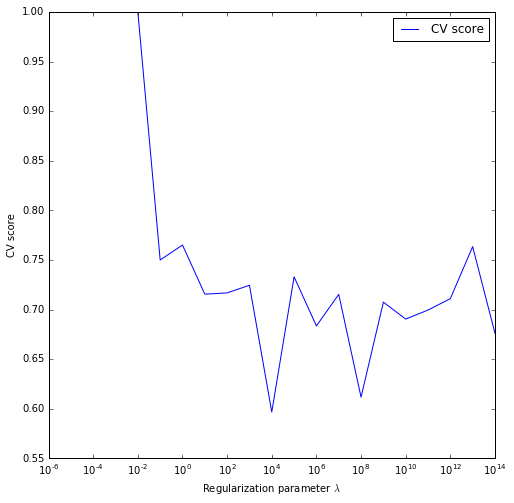

In [19]:
## Tuning for regularized logistic regression
# Parameters for tuning
regularization = 10. ** np.arange(-6, 15)

# To keep track of the best model
best_score = 0

# Run grid search for model with 5-fold cross validation
print '3-fold cross validation:'

class0_train = []
x_std = Standardize(with_mean=False).fit_transform(x)

for C in regularization:
    # Cross validation for every experiment
    k_folds = KFold(x.shape[0], n_folds=3, shuffle=True)
    tot_scores = []
    class0_score = []
    class1_score = []
    for train_indices, validation_indices in k_folds:
        # Generate training data
        x_train_cv = x_std[train_indices]
        y_train_cv = y[train_indices]
        # Generate validation data
        x_validate = x_std[validation_indices]
        y_validate = y[validation_indices]
            
        # Fit weighted logit on training data
        wlogit=LogisticRegression(class_weight='balanced',penalty='l1',C=C)
        wlogit.fit(x_train_cv, y_train_cv)
        # Score on validation data
        tot_scores += [wlogit.score(x_validate, y_validate)]
        class0_score += [wlogit.score(x_validate[y_validate==0], y_validate[y_validate==0])]
        class1_score += [wlogit.score(x_validate[y_validate==1], y_validate[y_validate==1])]
        
    # Record and report accuracy
    tot_average_score = np.mean(tot_scores)
    class0_avg = np.mean(class0_score)
    class1_avg = np.mean(class1_score)
    print "C:", C, "Overall Score:", tot_average_score, "Class 0 score:", class0_avg, "Class 1 score:", class1_avg
    
    class0_train.append(class0_avg)
    
    
    # Update our record of the best parameters see so far
    if class1_avg > best_score:
        best_score = class1_avg
        best_C = C
    

print 'Chosen number of C:', best_C
print 'Best accuracy on conflict:', best_score



fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.semilogx(regularization, (class0_train), c='b', label='CV score')



ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel('CV score')

#ax.set_ylim((test_r_squared_plain-0.2, 1.2))
ax.legend(loc = 'best')

plt.show()

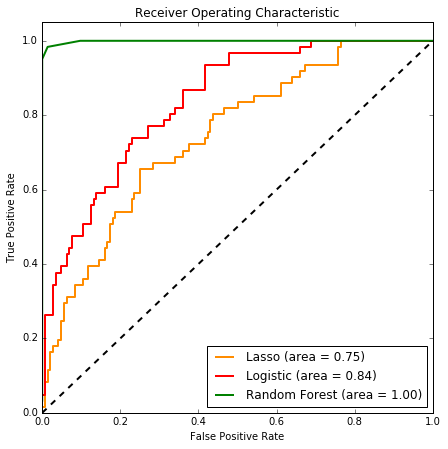

In [74]:
#ROC curve for 3 models
final_logit=LogisticRegression(class_weight='balanced',penalty='l1',C=best_C)
final_logit.fit(x,y)
y_pred_lass=final_logit.predict_proba(x)

fpr_lass, tpr_lass, thresholds = metrics.roc_curve(y, y_pred_lass[:,1], pos_label=1)
roc_auc_lass = auc(fpr_lass, tpr_lass)



wlogit = LogisticRegression(class_weight='balanced')
wlogit.fit(x,y)
y_pred_logit=wlogit.predict_proba(x)


fpr_logit, tpr_logit, thresholds = metrics.roc_curve(y, y_pred_logit[:,1], pos_label=1)
roc_auc_logit = auc(fpr_logit, tpr_logit)


brf = RandomForest(class_weight='balanced')
brf.fit(x,y)
y_pred_brf=brf.predict_proba(x)
y_pred2=brf.predict(x)


fpr_brf, tpr_brf, thresholds = metrics.roc_curve(y, y_pred_brf[:,1], pos_label=1)
roc_auc_brf = auc(fpr_brf, tpr_brf)


plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr_lass, tpr_lass, color='darkorange',
         lw=lw, label='Lasso (area = %0.2f)' % roc_auc_lass)
plt.plot(fpr_logit, tpr_logit, color='red',
         lw=lw, label='Logistic (area = %0.2f)' % roc_auc_logit)
plt.plot(fpr_brf, tpr_brf, color='green',
         lw=lw, label='Random Forest (area = %0.2f)' % roc_auc_brf)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()